# $P(n)$: GP model mixing

## Alexandra Semposki

### Date last edited: 31 January 2024

We would like to model mix the chiral EFT EOS with the perturbative QCD EOS for Symmetric Nuclear Matter (SNM) using an interpolant between the two regions of model validity. First we set up the two models as `dict`s and then we employ a simple Gaussian Process (GP) to handle the interpolation between the two.

#### Table of contents

1. [Bayesian Model Mixing as a GP](#bmm_gp) 
  1. [Speed of sound calculation](#cs2_gp)

In [1]:
# import packages
%load_ext autoreload
%autoreload 2

import gsum as gm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as scint
import scipy.interpolate as scinterp
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import scipy.stats as stats
import os
import sys
import scipy.optimize as opt
import pandas as pd
from collections import defaultdict
%matplotlib inline

In [2]:
import sys
sys.path.append('src/')
sys.path.append('data/')

In [3]:
# import plotting script from J. Melendez
from scripts import *
setup_rc_params()

In [4]:
# import classes for chiral and pQCD
from chiral_model import Chiral_model
from pqcd_reworked import PQCD
from gorda_model import Gorda

# import class to wrap gsum
from truncation_error import Truncation

# import class for speed of sound calculation
from utils import speed_of_sound

### Training data and model evaluations

Here the models are both evaluated at every training and testing point we'll be using, so that we can save this data and pick the proper training points and testing points for the GP later on.

In [5]:
# define density linspace for training and testing
density = np.linspace(0.05, 16.0, 600)

#instantiate pqcd EOS
pqcdk = PQCD(X=1,Nf=2) # X=1 standard for now; Nf=2 for two flavours of quarks

# take the density and invert to obtain the corresponding mu
n_q = density*3.0  # n_q [fm^-3]

# convert to GeV^3 for mu_q units
conversion_fm3 = ((1000.0)**(3.0))/((197.327)**(3.0)) # [fm^-3]  (do the opposite of this)
n0 = 0.16 
n_q = n_q/conversion_fm3

# invert for mu_FG and mu corresponding to chosen n_B
_, mu_n, mu_FG = pqcdk.inversion(n_mu=n_q)

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


## Loading GP data

In [6]:
# load training data from GPJaxEmcee calculation for plotting
tr_data = np.load('data/gpjaxemcee_data/gp_mean1_training_log.npz')
print(len(tr_data['mean']))

# load the GP evaluation data from GPJaxEmcee
gp_result = np.load('data/gpjaxemcee_data/gp_mean1_log.npz')
print(len(gp_result['mean']))

8
300


In [7]:
# density settings for evaluation set
density_test = density[::2]

In [8]:
# use the conversion from the pQCD code to see if this resolves things
convert_pqcd = np.load('pqcd_fg_data.npz')

# interpolate for a functional form to use 
convert_interp = scinterp.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density_test)

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="cs2_taweret"></a>

We need to extract the speed of sound from the pressure equation. The most direct way to do this is to integrate the $P(n)$ curve to get the energy density. 

$$
P(n) = n^{2} \frac{\partial (\varepsilon/n)}{\partial n}
$$

$$
\varepsilon(n) = n \left[\int_{min(n)}^{n} \frac{P(n)}{n^{2}} dn + \frac{\varepsilon(min(n))}{min(n)} \right],
$$

where $min(n)$ is 0.05 fm$^{-3}$, and $max(n)$ is 16.0 fm$^{-3}$.

After we achieve the energy density in this manner, we will then code the chemical potential as

$$
\mu = \frac{P(n) + \varepsilon(n)}{n},
$$

and finally obtain the speed of sound, given as

$$
c_{s}^{2}(n) = \frac{\partial P}{\partial n } / \frac{\partial \varepsilon}{\partial n} = \frac{1}{\mu} \frac{\partial P(n)}{\partial n}.
$$

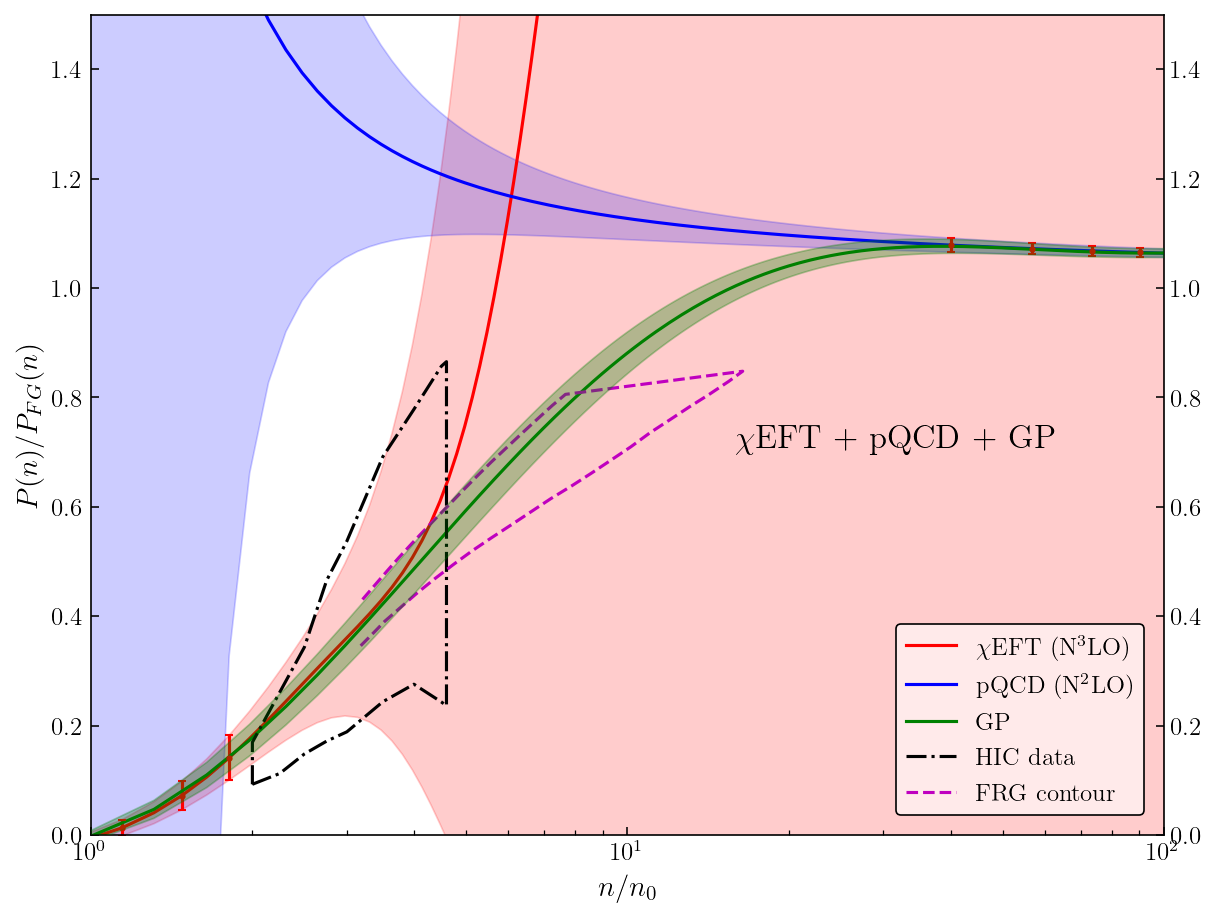

In [9]:
# import the data from the ChEFT, pQCD files directly as the models
chiral_result = np.load('pressure_chiral_data_scaled_cpk.npz')
pqcd_result = np.load('pressure_pqcd_data_scaled_expQ.npz')

# plot BMM result
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(1.0, max(density/n0))
ax.set_ylim(0.0,1.5)
ax.tick_params(axis='both', which='major', labelsize=12, labelright=True, right=True)
ax.tick_params(axis='both', which='minor', labelsize=10, labelright=True)
ax.text(0.9,0.5, r'$\chi$EFT + pQCD + GP', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)

colors = ['r', 'b', 'g']
labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed model']

# assign means and std devs for easier use
mean_chiral = chiral_result['mean'][:,3]
mean_pqcd = pqcd_result['mean'][:,2]
std_dev_chiral = chiral_result['std_dev'][:,3]
std_dev_pqcd = pqcd_result['std_dev'][:,2]

# model means
ax.plot(chiral_result['density']/n0, chiral_result['mean'][:,3], color=colors[0], label=labels[0])
ax.plot(pqcd_result['density']/n0, pqcd_result['mean'][:,2], color=colors[1], label=labels[1])

# PPD mean (testing data array)
ax.plot(gp_result['density']/n0, gp_result['mean'], color='g', label='GP')

# model uncertainties
ax.fill_between(chiral_result['density']/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, color=colors[0], alpha=0.2)
ax.fill_between(pqcd_result['density']/n0, mean_pqcd - 1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                color=colors[1], alpha=0.2)

# PPD band (testing data array)
ax.fill_between(gp_result['density']/n0, gp_result['mean']-1.0*gp_result['std'], gp_result['mean']+1.0*gp_result['std'],
                       zorder=5, facecolor='g', edgecolor='g', alpha=0.3)

# import contours and plot
df = pd.read_csv('data/contour_scaled.csv')
df_frg = pd.read_csv('data/frg_data_pressure.csv')
df_hhic = pd.read_csv('data/hic_data_huth.csv')
df_hfrg = pd.read_csv('data/frg_data_huth.csv')

# frg unscaling
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density_test)])
hbarc = 197.327 # MeV fm

# contour kf_s calculated here
contour_kf_s_fg = fermi_momentum(density=density_test, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.16*df_frg['n/n0'], degeneracy=4)

for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
p_fg = pqcd_convert_arr
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', label='FRG contour')

# plot the training points
plt.errorbar(tr_data["density"]/n0, tr_data["mean"], yerr=tr_data["std"], \
             color='red', fmt='o', markersize=2, capsize=2)

# legend
ax.set_xscale('log')
ax.legend(loc='lower right', fontsize=12)
plt.show()

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="cs2_gp"></a>

In [10]:
# want to only use data above saturation
dens_cs2 = density_test
print(dens_cs2[0])

0.05


In [11]:
# unscale the variables using what we've got for now and store in a dict
pres_dict = {
    'mean': gp_result['mean']*p_fg,
    'std_dev': gp_result['std']*p_fg
}

# 0.05 values for this calculation
en_0 = 46.52745253488445 
en_0_lower = 46.525
en_0_upper = 46.530

edens_dict = {
    'mean': en_0, 
    'lower': en_0_lower,
    'upper': en_0_upper
}

# call speed of sound function
cs2, edens_info, mu_int = speed_of_sound(dens_cs2, pres_dict, edens_dict)

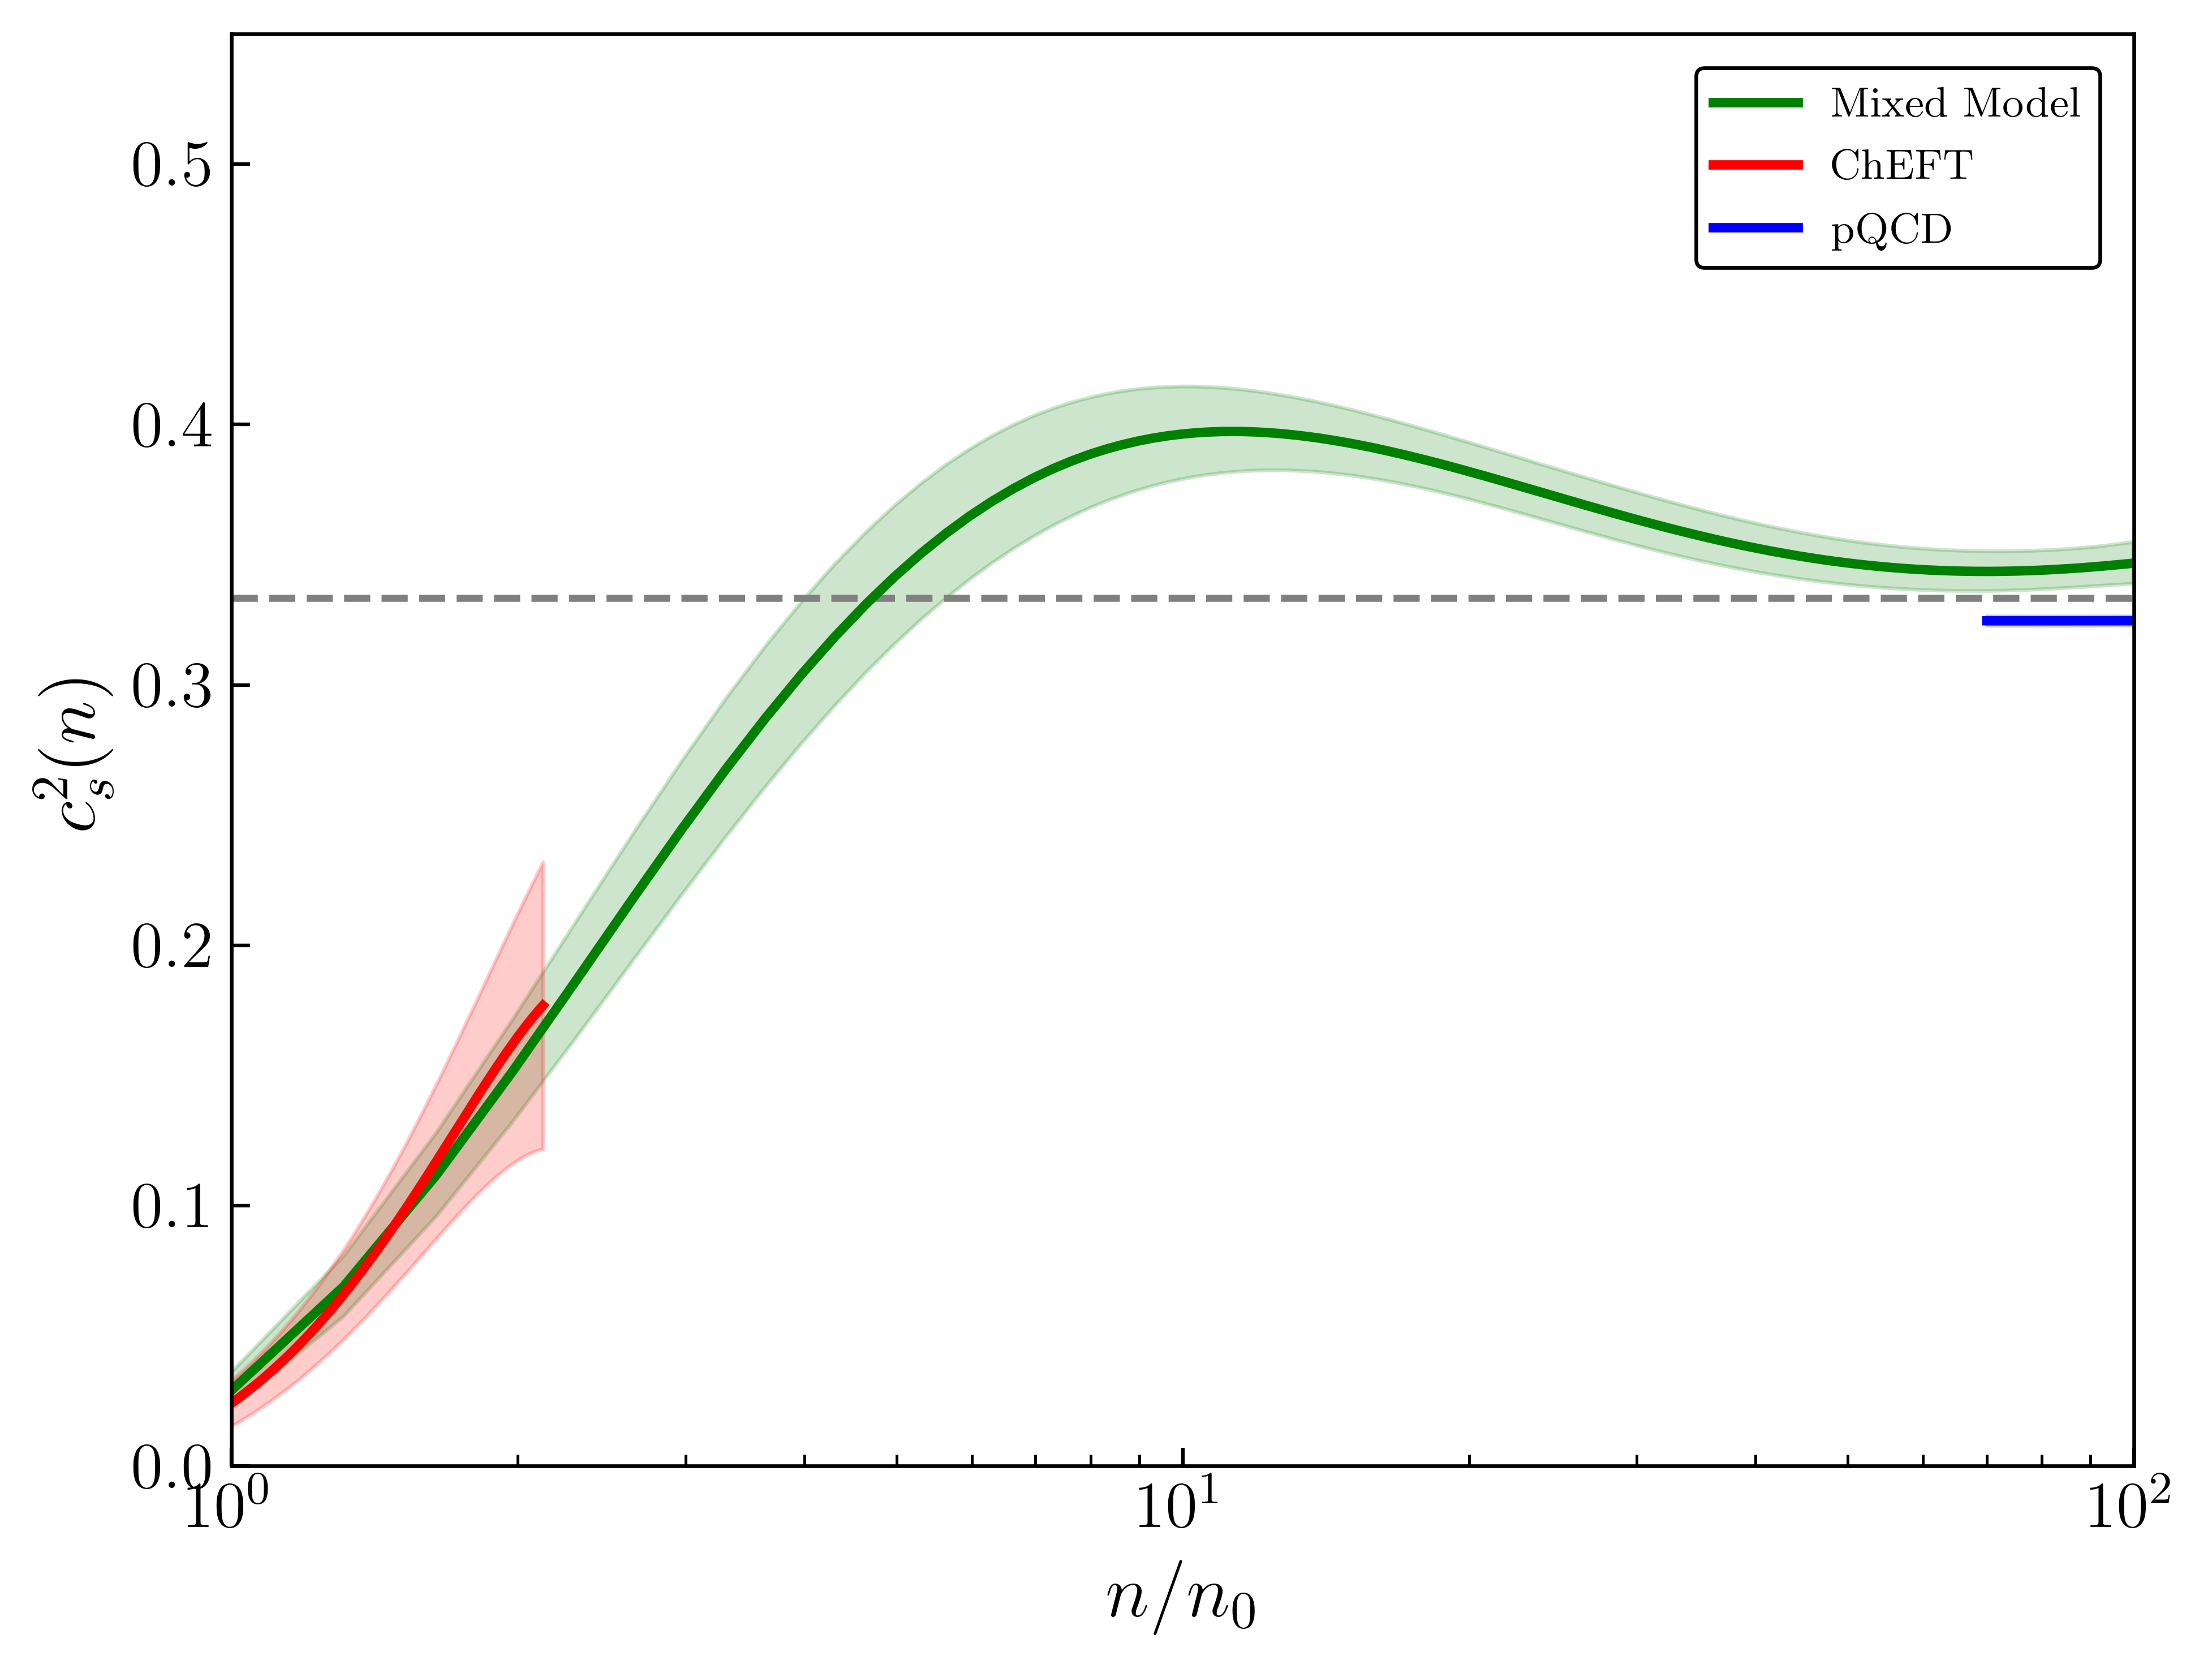

In [12]:
# speed of sound
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 600   # change for paper plots
mpl.rcParams['font.size'] = 8
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
WIDE_IMG_WIDTH = 800
NARROW_IMG_WIDTH = 400

plt.axhline(y=0.333333, color='grey', linestyle='dashed')

# old constraint :60
plt.plot(dens_cs2/n0, cs2['mean'], color='g', linewidth=2, label=r'Mixed Model')
plt.fill_between(dens_cs2/n0, cs2['lower'], cs2['upper'], color='g', alpha=0.2)

# plot the result from chiral to see differences
npzfile = np.load('data/eos_data/speedofsoundchiral.npz')
chiral_mean = npzfile['mean']
chiral_std = npzfile['std']
chiral_dens = npzfile['density']
plt.plot(chiral_dens/n0, chiral_mean[:,3], color='red', linewidth=2, label=r'ChEFT')
plt.fill_between(chiral_dens/n0, chiral_mean[:,3]+chiral_std[:,3], chiral_mean[:,3]-chiral_std[:,3], alpha=0.2, color='red')

# plot the result from pqcd to see differences
npzfile2 = np.load('data/eos_data/pqcd_cs2_11.2.npz')
pqcd_cs2 = npzfile2['mean']
pqcd_dens = npzfile2['density']
pqcd_lower = npzfile2['lower']
pqcd_upper = npzfile2['upper']
plt.plot(pqcd_dens/n0, pqcd_cs2, color='blue', linewidth=2, label=r'pQCD')
plt.fill_between(pqcd_dens/n0, pqcd_lower, pqcd_upper, color='blue', alpha=0.2)

# plot individual calculation from pQCD as well (using same method, but no energy density integration)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 0.55)
plt.xlabel(r'$n/n_{0}$', fontsize=16)
plt.ylabel(r'$c_{s}^{2}(n)$', fontsize=16)
plt.xscale('log')
plt.legend()
plt.show()

## Creating the poster plot

Now we need to use both the $P(n)$ result and the $c_{s}^{2}(n)$ result in one set of subplots so that we can present them side-by-side in the poster for the INPP Open House. We can simply call the data files and load them into the plot here, if we wish to avoid any running of the main code above, since we are only using the GP result for the poster and not the totally mixed result.

In [13]:
# load the data for both plots
poster_chi = np.load('data/eos_data/pressure_chiral_data_scaled_cpk.npz')
poster_pqcd = np.load('data/eos_data/pressure_pqcd_data_scaled_expQ.npz')
poster_gp = gp_result
poster_cs2_chi = np.load('data/eos_data/speedofsoundchiral.npz')
poster_cs2_pqcd = np.load('data/eos_data/pqcd_cs2_11.2.npz')

# contour plot data
df = pd.read_csv('data/contour_scaled.csv')
df_frg = pd.read_csv('data/frg_data_pressure.csv')
df_hhic = pd.read_csv('data/hic_data_huth.csv')
df_hfrg = pd.read_csv('data/frg_data_huth.csv')

In [14]:
# set up other variables
n0 = 0.16 # fm^-3

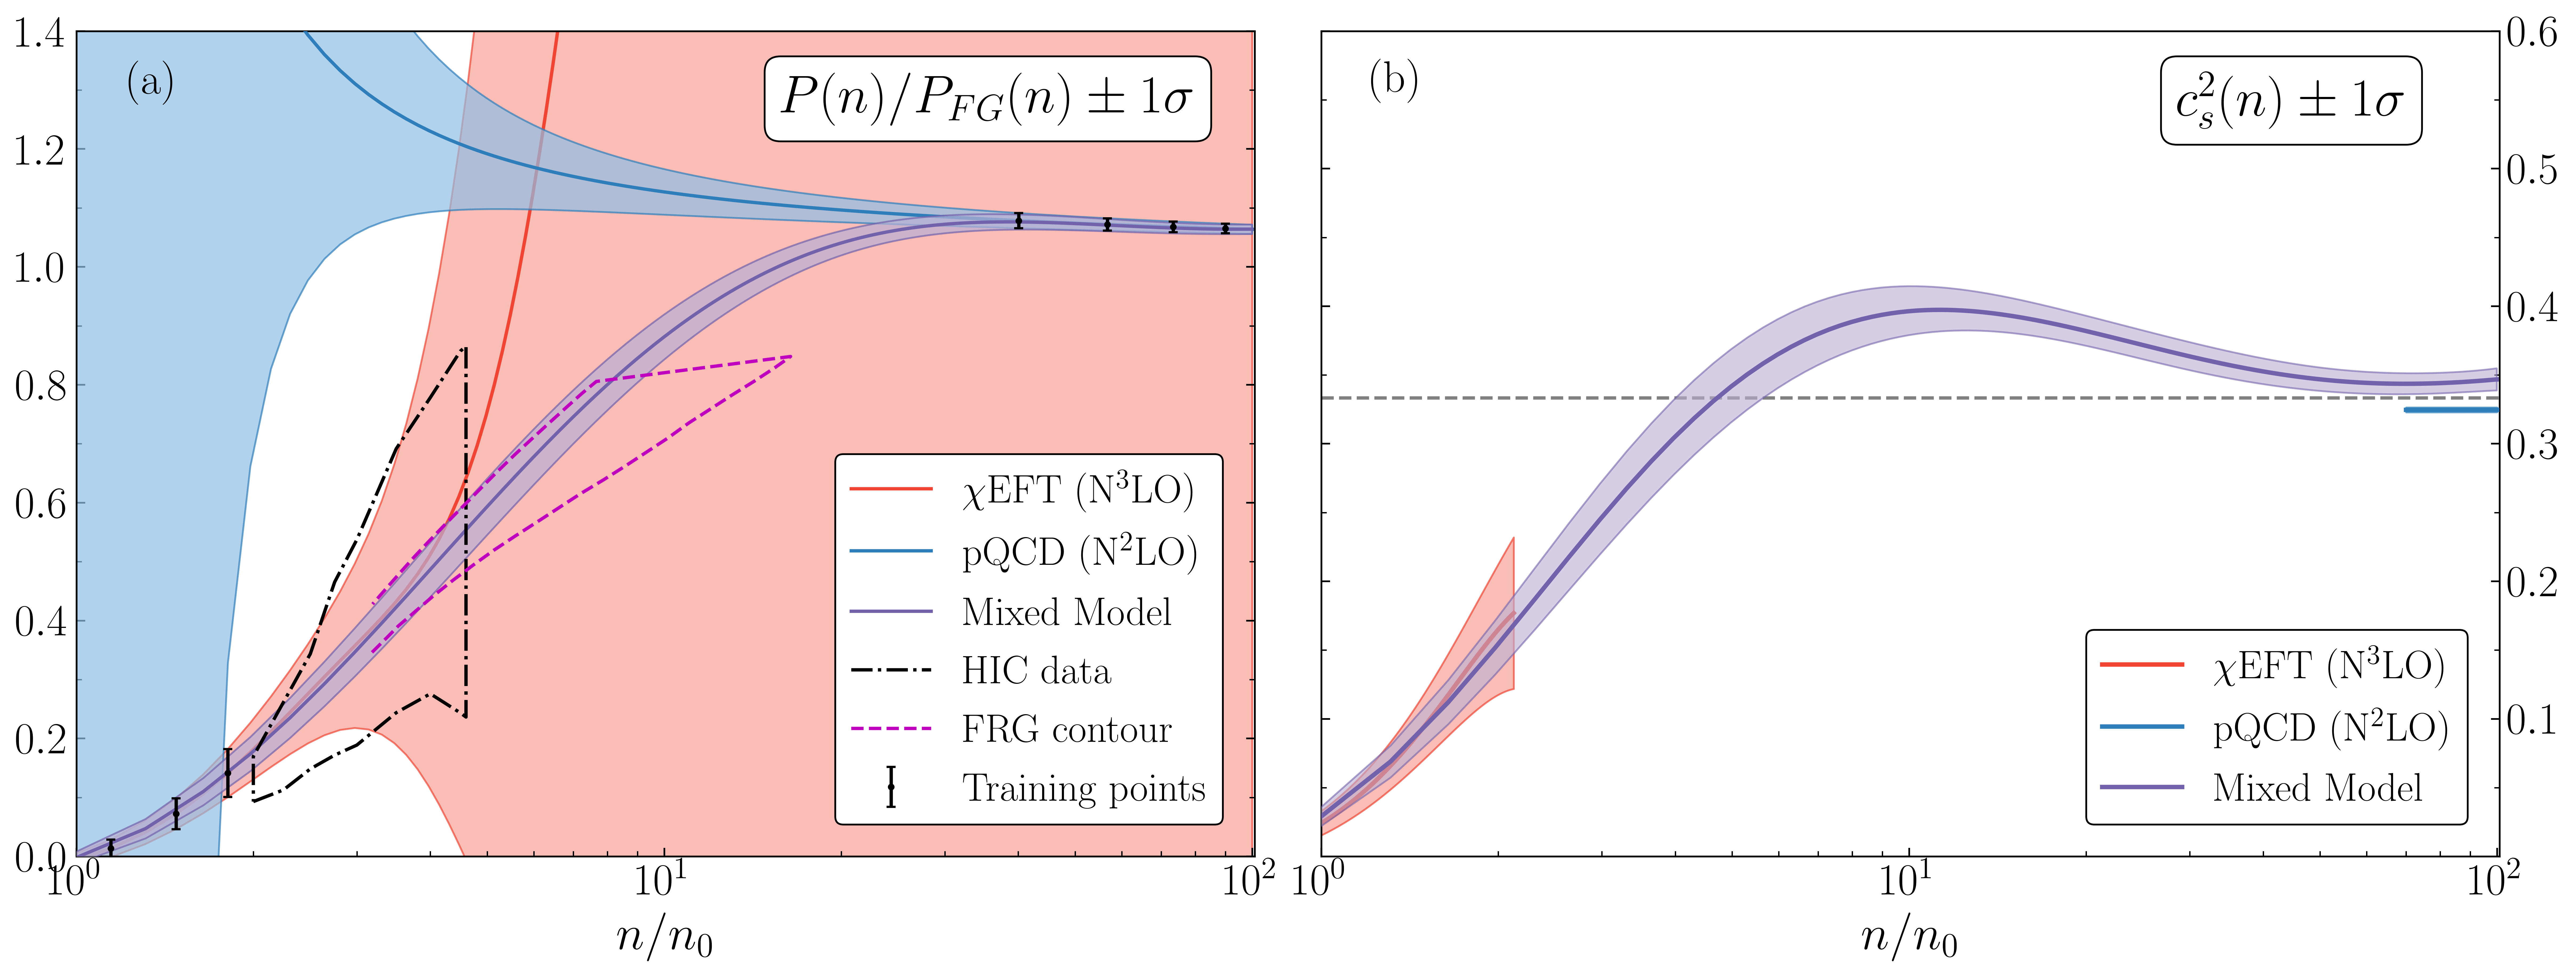

In [15]:
# set up the plot requirements
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=600, sharex='col')
#fig.patch.set_alpha(0.0)
ax[0].set_xlim(1.00, max(density/n0)+1.)
ax[0].set_ylim(0.0,1.4)
ax[0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0].xaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0].text(1.5, 1.35, r'(a)', ha='right', va='top', fontsize=20)
ax[0].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[0].set_xscale('log')

ax[1].set_xlim(1., max(density/n0)+1.)
ax[1].set_ylim(1e-6,0.6)
ax[1].xaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1].text(1.5, 0.58, r'(b)', ha='right', va='top', fontsize=20)
ax[1].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1].set_xscale('log')

orders = [0,1,2]

# plotting assistance
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# assign means and std devs for easier use
mean_chiral = poster_chi['mean'][:,3]
mean_pqcd = poster_pqcd['mean'][:,2]
std_dev_chiral = poster_chi['std_dev'][:,3]
std_dev_pqcd = poster_pqcd['std_dev'][:,2]

# pressure data

# model means and uncertainties
ax[0].fill_between(poster_chi['density']/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[0].plot(poster_chi['density']/n0, poster_chi['mean'][:,3], color=colors[0], zorder=1, label=labels[0])

ax[0].fill_between(poster_pqcd['density']/n0, mean_pqcd - 1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0].plot(poster_pqcd['density']/n0, poster_pqcd['mean'][:,2], zorder=3, color=colors[1], label=labels[1])

# PPD band (testing data array)
ax[0].fill_between(poster_gp['density']/n0, poster_gp['mean']-1.0*poster_gp['std'], poster_gp['mean']+ \
                   1.0*poster_gp['std'],
                       zorder=5, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0].plot(poster_gp['density']/n0, poster_gp['mean'], color=colors[2], zorder=10, label='Mixed Model')

# frg unscaling
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density_test)])
hbarc = 197.327 # MeV fm

# contour kf_s calculated here
contour_kf_s_fg = fermi_momentum(density=density_test, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.16*df_frg['n/n0'], degeneracy=4)

for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
p_fg = pqcd_convert_arr
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax[0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', zorder=10, label='HIC data')
ax[0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', zorder=10, label='FRG contour')

# plot the training points
ax[0].errorbar(tr_data["density"]/n0, tr_data["mean"], yerr=tr_data["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[0].legend(loc='lower right', facecolor='w', fontsize=18)

# speed of sound data 
ax[1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[1].fill_between(poster_cs2_chi['density']/n0, poster_cs2_chi['mean'][:,3]+poster_cs2_chi['std'][:,3], \
                 poster_cs2_chi['mean'][:,3]-poster_cs2_chi['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1].plot(poster_cs2_chi['density']/n0, poster_cs2_chi['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
plt.plot(pqcd_dens/n0, pqcd_cs2, color=colors[1], zorder=3, linewidth=2, label=r'pQCD (N$^2$LO)')
plt.fill_between(pqcd_dens/n0, pqcd_lower, pqcd_upper, zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[1].fill_between(density_test/n0, cs2['lower'], cs2['upper'], zorder=4, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1].plot(density_test/n0, cs2['mean'], color=colors[2], linewidth=2, zorder=5, label=r'Mixed Model')

ax[1].legend(loc='lower right', facecolor='w', fontsize=18)
plt.show()
fig.savefig('subplot_mean1_result.PNG', bbox_inches='tight')